Q1 – Why might questionnaire-based risk tolerance be unreliable during crises?

Because the answers are driven by fear and short-term emotions, not stable long-term preferences.

Q2 – What is the business advantage of algorithmically inferring risk tolerance from behavior?

It uses what clients actually do, is more stable over time, can auto-update, and better supports suitability/KYC at scale.

In [3]:
# 1.1 Imports de base

# !pip install pandas scikit-learn matplotlib seaborn streamlit --quiet

import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from pathlib import Path

# Pour ignorer quelques warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 1.2 Load the SCF panel

DATAFILE = Path("SCFP2009panel.xlsx")
assert DATAFILE.exists(), "Put SCFP2009panel.xlsx in this folder."

dataset = pd.read_excel(DATAFILE)

dataset.shape, type(dataset)


((19285, 515), pandas.core.frame.DataFrame)

Q3 – How many rows and columns do you see?

(19285, 515): 19,285 rows and 515 columns.


Q4 – What does a single row represent in business terms?
One household, with its demographics, income, wealth, and portfolio in 2007 and 2009.



Q5 – Which columns look like potential “leaky” features if we want a 2007-based predictor?
All variables using 2009 info: columns ending in 09 and anything derived from them (RiskFree09, Risky09, RT09, etc.).

In [5]:
# 2.1 Compute risk tolerance in 2007 and 2009 + PercentageChange

# Average SP500 during 2007 and 2009 (for normalization)
Average_SP500_2007 = 1478
Average_SP500_2009 = 948

# Risk-free and risky assets (2007)
dataset["RiskFree07"] = (
    dataset["LIQ07"] + dataset["CDS07"] + dataset["SAVBND07"] + dataset["CASHLI07"]
)
dataset["Risky07"] = (
    dataset["NMMF07"] + dataset["STOCKS07"] + dataset["BOND07"]
)
dataset["RT07"] = dataset["Risky07"] / (dataset["Risky07"] + dataset["RiskFree07"])

# Risk-free and risky assets (2009)
dataset["RiskFree09"] = (
    dataset["LIQ09"] + dataset["CDS09"] + dataset["SAVBND09"] + dataset["CASHLI09"]
)
dataset["Risky09"] = (
    dataset["NMMF09"] + dataset["STOCKS09"] + dataset["BOND09"]
)
dataset["RT09"] = (
    dataset["Risky09"] / (dataset["Risky09"] + dataset["RiskFree09"])
    * (Average_SP500_2009 / Average_SP500_2007)
)

# Work copy
dataset2 = copy.deepcopy(dataset)

# Percentage change in risk tolerance
dataset2["PercentageChange"] = np.abs(dataset2["RT09"] / dataset2["RT07"] - 1)

dataset2.head()


,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09,PercentageChange
0,1,11,11668.134198,47,3,12,2,1,0,2,...,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422,inf
1,1,12,11823.456494,47,3,12,2,1,0,2,...,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036,inf
2,1,13,11913.228354,47,3,12,2,1,0,2,...,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876,inf
3,1,14,11929.394266,47,3,12,2,1,0,2,...,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429,inf
4,1,15,11917.722907,47,3,12,2,1,0,2,...,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410,inf


In [6]:
# Check and drop missing / infinite values

print("Null Values =", dataset2.isnull().values.any())

dataset2 = dataset2.dropna(axis=0)
dataset2 = dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

print("Null Values =", dataset2.isnull().values.any())
dataset2.shape


Null Values = True
Null Values = False


(7956, 522)

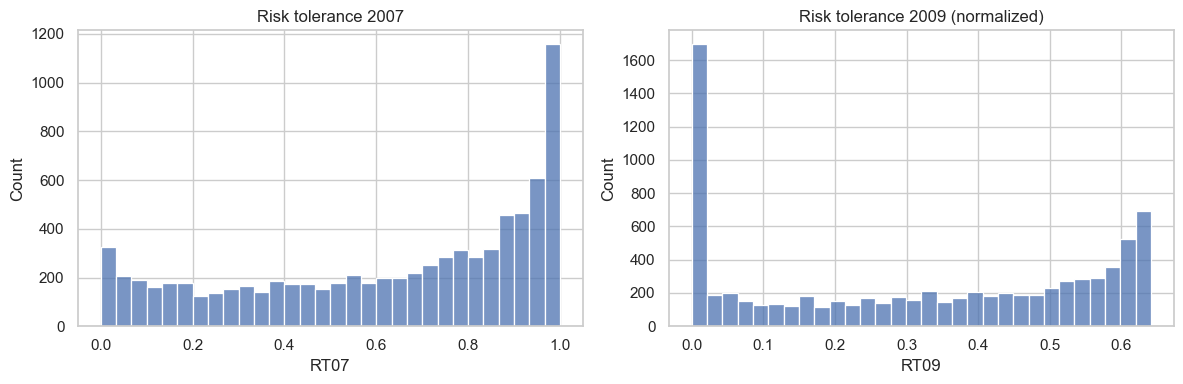

In [7]:
# 2.2 Histograms of RT07 and RT09 (clipped to [0,1])

dataset2["RT07"] = dataset2["RT07"].clip(0, 1)
dataset2["RT09"] = dataset2["RT09"].clip(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(dataset2["RT07"], bins=30, ax=axes[0])
axes[0].set_title("Risk tolerance 2007")

sns.histplot(dataset2["RT09"], bins=30, ax=axes[1])
axes[1].set_title("Risk tolerance 2009 (normalized)")

plt.tight_layout()
plt.show()


In [8]:
# Filter investors with stable risk tolerance: PercentageChange <= 10%

dataset2 = dataset2[dataset2["PercentageChange"] <= 0.10].copy()
dataset2.shape


(355, 522)

In [9]:
# Build final target: TrueRiskTolerance

dataset3 = copy.deepcopy(dataset2)

# RT07 and RT09 already clipped
dataset3["TrueRiskTolerance"] = (dataset3["RT07"] + dataset3["RT09"]) / 2

# Drop intermediate columns
dataset3 = dataset3.drop(columns=["RT07", "RT09", "PercentageChange"])

dataset3[["TrueRiskTolerance"]].head()


,TrueRiskTolerance
60,0.199511
425,0.641458
1122,0.589943
1190,0.434127
1228,0.228218


6 – What business behavior does “PercentageChange ≤ 10%” capture?

Households whose risk tolerance stays stable through the crisis, i.e. steady, disciplined investors.



Q7 – Why do we clip risk tolerance to [0,1]?

Because it is a proportion of risky assets; by definition it must lie between 0 and 1, and clipping removes small out-of-range artefacts.




Q8 – Looking at the two histograms, what crisis-era behavioral shift do you observe?
The 2009 distribution shifts left: more low-risk portfolios and fewer highly risky ones after the crisis.

In [10]:
# 3.1 Select a subset of 2007 features + target

keep = [
    "AGE07",
    "EDCL07",
    "MARRIED07",
    "KIDS07",
    "OCCAT107",
    "INCOME07",
    "RISK07",
    "NETWORTH07",
    "TrueRiskTolerance",
]

Xy = dataset3[keep].dropna().copy()
X = Xy.drop(columns=["TrueRiskTolerance"])
y = Xy["TrueRiskTolerance"]

X.shape, y.shape


((355, 8), (355,))

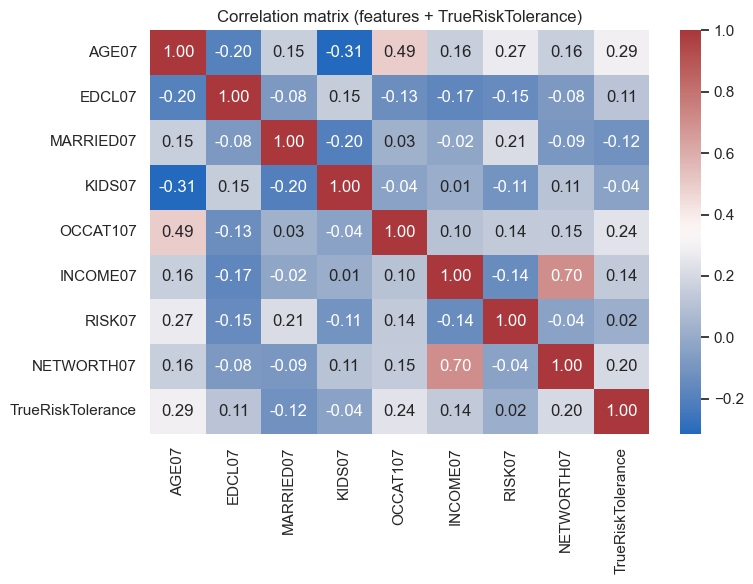

In [11]:
# 3.2 Correlation matrix between features and target

corr = Xy.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (features + TrueRiskTolerance)")
plt.tight_layout()
plt.show()


<Figure size 1400x1400 with 0 Axes>

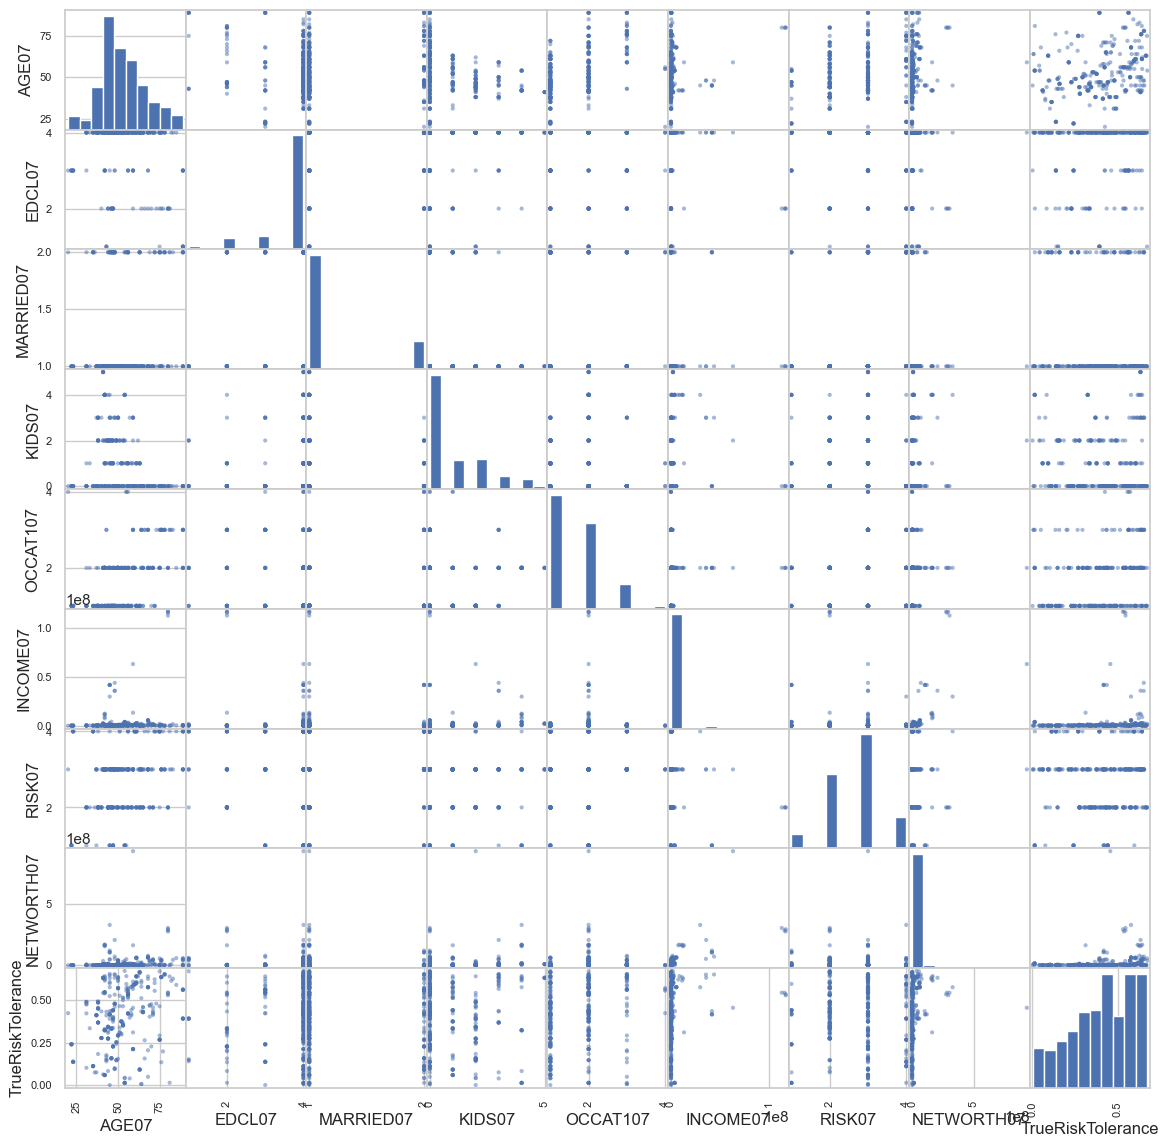

In [12]:
# 3.3 Scatterplot matrix (can be slow)

from pandas.plotting import scatter_matrix

plt.figure(figsize=(14, 14))
scatter_matrix(Xy, figsize=(14, 14))
plt.show()


Q9 – Which features correlate positively with TrueRiskTolerance? Which correlate negatively?
Positively: RISK07, INCOME07, NETWORTH07, EDCL07.
Negatively: AGE07, KIDS07, often MARRIED07 slightly.



Q10 – Why do we exclude all 2009 variables from features?
They contain future information; using them would create data leakage and unrealistic predictive performance.

In [13]:
# 4.1 Train/validation split

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

validation_size = 0.20
seed = 3

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, y, test_size=validation_size, random_state=seed
)

len(X_train), len(X_validation)


(284, 71)

In [14]:
# Naïve baseline: always predict the mean of the training target

y_mean = Y_train.mean()
y_pred_baseline = np.full_like(Y_validation, y_mean, dtype=float)

mae_baseline = mean_absolute_error(Y_validation, y_pred_baseline)
rmse_baseline = mean_squared_error(Y_validation, y_pred_baseline)  # MSE here
r2_baseline = r2_score(Y_validation, y_pred_baseline)

mae_baseline, rmse_baseline, r2_baseline


(0.15296853954527648, 0.03416689742849996, -0.04737839427394741)

Q11 – Why compute a naïve baseline?
To have a minimal reference; if a model cannot beat “predict the mean”, it adds no value.

Q12 – Which metric (MAE, RMSE, R²) would you prioritize for this business task, and why?
MAE and R²: MAE is easy to interpret in business terms, R² summarizes overall explanatory power and lets us compare models.

Q13 – What does R² negation mean?
A negative R² means the model is worse than predicting a constant (the mean of the target).

In [15]:
# 4.2 10-fold CV, R² metric, compare different models

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
)

num_folds = 10
scoring = "r2"
cv = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

models = [
    ("LR", Pipeline([
        ("scaler", StandardScaler()),
        ("m", LinearRegression())
    ])),
    ("LASSO", Pipeline([
        ("scaler", StandardScaler()),
        ("m", Lasso(alpha=0.01, max_iter=5000))
    ])),
    ("EN", Pipeline([
        ("scaler", StandardScaler()),
        ("m", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000))
    ])),
    ("KNN", Pipeline([
        ("scaler", StandardScaler()),
        ("m", KNeighborsRegressor(n_neighbors=7))
    ])),
    ("CART", DecisionTreeRegressor(random_state=seed)),
    ("SVR", Pipeline([
        ("scaler", StandardScaler()),
        ("m", SVR(C=2.0, epsilon=0.02, kernel="rbf"))
    ])),
    ("ABR", AdaBoostRegressor(random_state=seed)),
    ("GBR", GradientBoostingRegressor(random_state=seed)),
    ("RFR", RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)),
    ("ETR", ExtraTreesRegressor(n_estimators=200, random_state=seed, n_jobs=-1)),
]

results = []
names = []

print("=== 10-fold CV (R²) ===")
for name, model in models:
    cv_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: mean={cv_scores.mean():.3f}  std={cv_scores.std():.3f}")


=== 10-fold CV (R²) ===
LR: mean=0.103  std=0.179
LASSO: mean=0.122  std=0.110
EN: mean=0.123  std=0.127
KNN: mean=0.256  std=0.144
CART: mean=0.541  std=0.226
SVR: mean=0.379  std=0.168
ABR: mean=0.379  std=0.154
GBR: mean=0.619  std=0.143
RFR: mean=0.699  std=0.105
ETR: mean=0.698  std=0.144


Q14 – Which model ranks best by mean CV R²? Are tree ensembles clearly ahead of linear baselines?
 
RandomForestRegressor has the best mean CV R² (≈ 0.70), slightly ahead of ExtraTrees and GradientBoosting. Yes, tree ensembles are clearly ahead of linear baselines.


In [16]:
# 5.1 Hyperparameter tuning of RandomForest via GridSearch

from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 6, 10],
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
)

grid_result = grid.fit(X_train, Y_train)

print("Best CV R²:", grid_result.best_score_)
print("Best params:", grid_result.best_params_)

means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.6f} ({stdev:.6f}) with: {param}")


Best CV R²: 0.7022342614722383
Best params: {'max_depth': None, 'n_estimators': 150}
0.688536 (0.110828) with: {'max_depth': None, 'n_estimators': 50}
0.702177 (0.095863) with: {'max_depth': None, 'n_estimators': 100}
0.702234 (0.102348) with: {'max_depth': None, 'n_estimators': 150}
0.699250 (0.105373) with: {'max_depth': None, 'n_estimators': 200}
0.591947 (0.142995) with: {'max_depth': 6, 'n_estimators': 50}
0.610202 (0.130648) with: {'max_depth': 6, 'n_estimators': 100}
0.611457 (0.131571) with: {'max_depth': 6, 'n_estimators': 150}
0.610252 (0.131649) with: {'max_depth': 6, 'n_estimators': 200}
0.685500 (0.117320) with: {'max_depth': 10, 'n_estimators': 50}
0.699298 (0.100916) with: {'max_depth': 10, 'n_estimators': 100}
0.697509 (0.106344) with: {'max_depth': 10, 'n_estimators': 150}
0.695625 (0.107081) with: {'max_depth': 10, 'n_estimators': 200}


Q15 – When would you tune max_depth, max_features, or min_samples_leaf?
When trees/forests overfit or show high variance; we tune them to reduce complexity and variance and improve generalization.

In [17]:
# 6.1 Fit best model and evaluate on train and validation

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

best_rf = grid_result.best_estimator_
best_rf.fit(X_train, Y_train)

# Training performance
pred_train = best_rf.predict(X_train)
print("Train R²:", r2_score(Y_train, pred_train))

# Validation performance
pred_val = best_rf.predict(X_validation)
print("Validation R²:", r2_score(Y_validation, pred_val))
print("Validation MSE:", mean_squared_error(Y_validation, pred_val))
print("Validation MAE:", mean_absolute_error(Y_validation, pred_val))


Train R²: 0.9634907699436531
Validation R²: 0.7714091693779455
Validation MSE: 0.007456941546300922
Validation MAE: 0.0438240876117408


Q16 – If validation R² were disappointing, what would you try next?

If validation R² was low, I would first check the data (leaks, outliers, wrong types), then work on feature engineering (log of income/wealth, interactions, maybe segmentation by groups). I’d also tune the hyperparameters more systematically and try a few alternative models to see if performance is more stable.

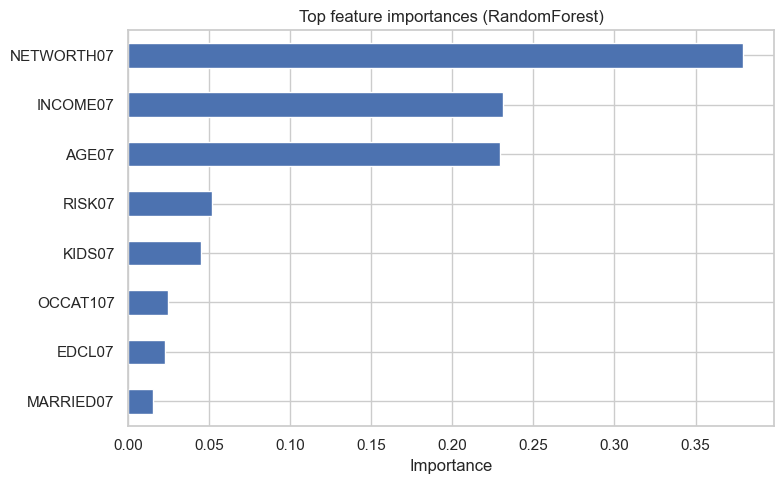

NETWORTH07    0.379386
INCOME07      0.231188
AGE07         0.229517
RISK07        0.052028
KIDS07        0.045200
OCCAT107      0.024393
EDCL07        0.023020
MARRIED07     0.015268
dtype: float64

In [18]:
# 6.2 Feature importances

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
fi_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 5))
fi_sorted.tail(10).plot(kind="barh")
plt.title("Top feature importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

fi_sorted.sort_values(ascending=False).head(10)


Q17 – Do importances align with the correlations you observed earlier?

Yes, they do. Wealth, income and age are among the most important features, together with the declared risk attitude, which is exactly what we saw in the correlations and what we’d expect from an economic point of view


Q18 – Which of these features might need governance/ethics review before production use?

I would flag age, marital status, number of kids and occupation. These variables are linked to sensitive or potentially discriminatory dimensions, so their use should be reviewed and justified from a fairness and compliance perspective.

In [19]:
# 6.3 Save & reload the model (for a robo-advisor/dashboard)

import pickle

FILENAME = "your_model.sav"

# Save
with open(FILENAME, "wb") as f:
    pickle.dump(best_rf, f)

# Reload
with open(FILENAME, "rb") as f:
    loaded_model = pickle.load(f)

# Quick check
pred_val_loaded = loaded_model.predict(X_validation)
print("Reloaded model R²:", r2_score(Y_validation, pred_val_loaded))
print("Reloaded model MSE:", mean_squared_error(Y_validation, pred_val_loaded))
print("Reloaded model MAE:", mean_absolute_error(Y_validation, pred_val_loaded))


Reloaded model R²: 0.7714091693779455
Reloaded model MSE: 0.007456941546300922
Reloaded model MAE: 0.0438240876117408


Q19 – Why is it essential to save the preprocessing steps with the model when you have them?

Because the model was trained on transformed inputs. In production, if we don’t apply exactly the same preprocessing (same features, same order, same scaler parameters), the inputs won’t match what the model learned and the predictions can become wrong or inconsistent.